In [27]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [28]:
print(tf.__version__)

2.11.0


In [29]:
#table_id='new_incident'
table_id='test_incident'
# table_id='validation_incident'

projectId='pongthorn'
dataset_id='DemoSMartDW'
REGION="asia-southeast1"

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Bi_Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Bi_Prediction_{table_id}.csv'
    
isLocalModel=True

isBQToCSV=True

PATH_FOLDER_ARTIFACTS="model_binary"  

modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True


In [30]:
# from google.oauth2 import service_account
# mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    bqclient= bigquery.Client(project=projectId)
    # bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                227 non-null    Int64  
 1   severity_name              227 non-null    object 
 2   sla                        227 non-null    object 
 3   product_type               227 non-null    object 
 4   brand                      227 non-null    object 
 5   service_type               227 non-null    object 
 6   incident_type              227 non-null    object 
 7   open_to_close_hour         227 non-null    float64
 8   response_to_resolved_hour  227 non-null    float64
 9   label_multi_severity       227 non-null    Int64  
 10  label_binary_severity      227 non-null    Int64  
dtypes: Int64(3), float64(2), object(6)
memory usage: 20.3+ KB
None



# Load and Map Data Test

In [31]:
if  localFile:
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

In [33]:
mapping_file="incident_sevirity_to_binary.json"

with open(mapping_file, 'r') as json_file:
 map_sevirity_to_class= json.load(json_file)
                                  
print(map_sevirity_to_class)


{'Normal': 0, 'Critical': 1}


In [34]:
if table_id=='new_incident':
    dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
    print(dfNewData.info())
elif table_id=='test_incident' or table_id=='validation_incident':
    
    dfNewData=dfNewData.rename(columns={'label_binary_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_multi_severity'])
    if 'id' not in dfNewData.columns.to_list():
        dfNewData=dfNewData.reset_index(drop=True)
        dfNewData = dfNewData.reset_index(level=0)
        dfNewData.rename(columns={"index": "id"},inplace=True)
        dfNewData['id']=dfNewData['id']+1
print(filePath)  

# dfNewData=dfNewData.sample(10)
print(dfNewData.info())
dfNewData.tail(10)


../../data/Bi_Prediction_test_incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         227 non-null    int64  
 1   severity_id                227 non-null    int64  
 2   severity_name              227 non-null    object 
 3   sla                        227 non-null    object 
 4   product_type               227 non-null    object 
 5   brand                      227 non-null    object 
 6   service_type               227 non-null    object 
 7   incident_type              227 non-null    object 
 8   open_to_close_hour         227 non-null    float64
 9   response_to_resolved_hour  227 non-null    float64
 10  severity                   227 non-null    int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 19.6+ KB
None


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
217,218,4,Cosmatic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Maintenance System,39.000000,39.00,0
218,219,4,Cosmatic,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,7.350000,7.35,0
219,220,4,Cosmatic,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,8.600000,8.00,0
220,221,4,Cosmatic,24x7 6Hrs Resolution Time,Software,YIP,Request,General Incident,1307.216667,1303.00,0
221,222,2,Major,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,General Incident,1.000000,1.00,1
222,223,3,Minor,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,Other Failure,4.000000,4.00,0
223,224,4,Cosmatic,24x7 4Hrs Resolution Time,Access Point,Cisco,Request,General Incident,1.500000,1.50,0
224,225,4,Cosmatic,8x5 4Hrs Response Time,Access Point,HPE,Request,General Incident,1.000000,0.50,0
225,226,4,Cosmatic,8x5 4Hrs Response Time,Access Point,HPE,Request,General Incident,1.000000,0.50,0
226,227,2,Major,8x5 4Hrs Response Time,Tape Library,HPE,Incident,Controller/Node Failure,12.383333,12.15,1


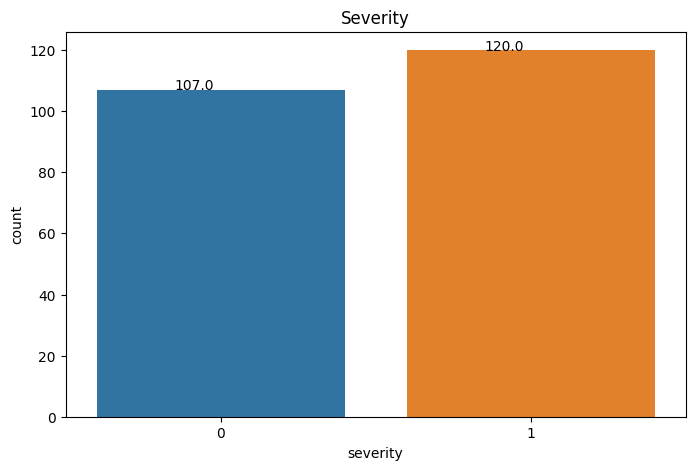

In [35]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

# Load Model from Directory to Predict

In [36]:
model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
print(f"Load from {PATH_FOLDER_ARTIFACTS}")
# model.summary()

Load from model_binary


In [37]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])

for  row_dict in dfNewData.to_dict(orient="records"):
      incident_id=row_dict['id']
      print(f"{incident_id} - {row_dict['severity']}") 
      for key_removed in unUsedColtoPredict:
       row_dict.pop(key_removed)
      # print(row_dict)  

      input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}
      predictionResult = model.predict(input_dict)

      prob = tf.nn.sigmoid(predictionResult[0])
      prob_pct=(100 * prob)   
      _class= 1 if prob[0]>=0.5 else 0  
      print(f"{prob_pct[0]} % at {_class} as 0(Normal)/1(Critcal)") # np.argmax(prob, axis=0
      
      
      pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
      # print(input_dict)  
   
      print("======================================================================================")

dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
dfPredictData=dfPredictData.drop(columns=['_id'])
dfPredictData=dfPredictData[['id','_predict_severity','severity']]
dfPredictData

1 - 1
1/1 [==============================] - 1s 692ms/step
59.97629928588867 % at 1 as 0(Normal)/1(Critcal)
2 - 1
1/1 [==============================] - 0s 100ms/step
59.58858871459961 % at 1 as 0(Normal)/1(Critcal)
3 - 0
1/1 [==============================] - 0s 90ms/step
91.37776184082031 % at 1 as 0(Normal)/1(Critcal)
4 - 0
1/1 [==============================] - 0s 110ms/step
3.235776662826538 % at 0 as 0(Normal)/1(Critcal)
5 - 1
1/1 [==============================] - 0s 74ms/step
80.61275482177734 % at 1 as 0(Normal)/1(Critcal)
6 - 1
1/1 [==============================] - 0s 57ms/step
80.6537094116211 % at 1 as 0(Normal)/1(Critcal)
7 - 1
1/1 [==============================] - 0s 72ms/step
94.924072265625 % at 1 as 0(Normal)/1(Critcal)
8 - 1
1/1 [==============================] - 0s 66ms/step
80.61449432373047 % at 1 as 0(Normal)/1(Critcal)
9 - 1
1/1 [==============================] - 0s 81ms/step
80.62523651123047 % at 1 as 0(Normal)/1(Critcal)
10 - 1
1/1 [=========================

,id,_predict_severity,severity
0,1,1,1
1,2,1,1
2,3,1,0
3,4,0,0
4,5,1,1
...,...,...,...
222,223,0,0
223,224,0,0
224,225,0,0
225,226,0,0


# Classification Rerport

In [38]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

In [39]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
# className.sort(reverse=True)


In [40]:
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1
actual-0,74,33
actual-1,22,98


In [41]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       107
           1       0.75      0.82      0.78       120

    accuracy                           0.76       227
   macro avg       0.76      0.75      0.75       227
weighted avg       0.76      0.76      0.76       227

